# Analysis of filter circuit

This notebook analyses the filter in the circuit diagram below:

![Circuit Diagram of filter](assets/images/circuit.png)

Now onto our filter. See handwritten notes for complete derivation but the transfer function $H(s)$ is:

$$H(s) = \frac{u_{in}}{u_{out}} =  \frac{CLR \cdot s^2 + R}{CLR \cdot s^2 + Ls + R}$$

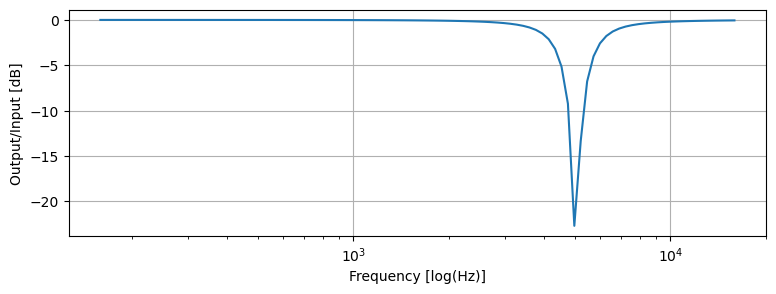

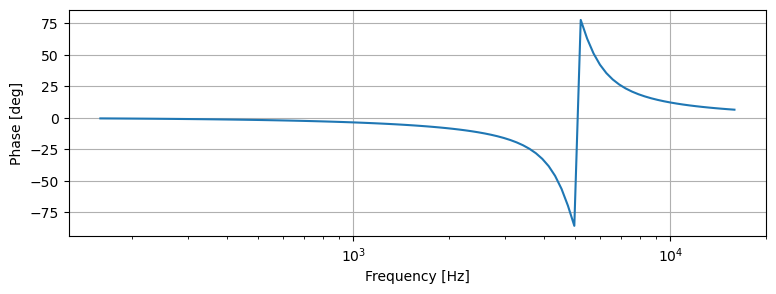

In [13]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

R = 5000
C = 20 * 10**(-9)
L = 50 * 10**(-3)

numerator = [C*L*R, 0, R]
denominator = [C*L*R, L, R]

LTI = signal.TransferFunction(numerator,denominator)

w, mag, phase = signal.bode(LTI)

# Convert rad/s to Hz
f=w/(2*np.pi)

plt.figure(figsize=(9, 3), dpi=100)
plt.semilogx(f,mag)
#plt.hlines(-3,min(f),max(f),linestyles="dotted",colors='r')
plt.xlabel('Frequency [log(Hz)]')
plt.ylabel('Output/Input [dB]')
plt.grid()
plt.figure(figsize=(9, 3), dpi=100)
plt.semilogx(f, phase)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [deg]')
plt.grid()
plt.show()

See handwritten note for expression for step response. The basics are that we use a convolution of the Heavyside function with the impulse response for our LTI-system. We don't know and don't need to know the impulse response, we use the Laplace Transform to find the laplace transform of the step response and then invert it to find the actual step response. 

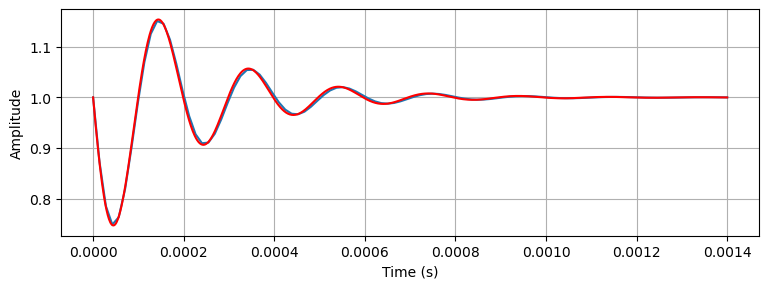

In [12]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

R = 5000
C = 20 * 10**(-9)
L = 50 * 10**(-3)

numerator = [C*L*R, 0, R]
denominator = [C*L*R, L, R]

LTI = signal.TransferFunction(numerator,denominator)
tDataLTI, yDataLTI = signal.step(LTI)

# Analytical expression
a = - 1 / (2*R*C)
b = np.sqrt(np.abs(L-4*R ** 2 * C /(4* R **2 * C ** 2 * L)))
c = np.sqrt(np.abs(L ** 2 - 4 * R ** 2 * C * L))

calcResponse = lambda t : 1 - 2*L / (c) * np.exp(t*a) * np.sin(b * t)

# Plot function

tInput = np.linspace(min(tDataLTI),max(tDataLTI),1000)

plt.figure(figsize=(9, 3), dpi=100)
plt.plot(tDataLTI, yDataLTI)
plt.plot(tInput, calcResponse(tInput), color='r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()

The next part of the assignment is to calculate the output from with each of the first five terms in a square wave fourier-series. The period of the square wave used here is $T = 0.2 \textrm{ ms} = 2 \cdot 10^{-4} \textrm{ s}$, which corresponds to $\omega = \frac{2\pi}{2 \cdot 10^{-4}} \textrm{ rad/s}$.

$$ $$

       f_i       A_i      A_oi       B_oi
1   5000.0  0.636620  0.026401 -87.623234
2  15000.0  0.212207  0.210706   6.818127
3  25000.0  0.127324  0.127045   3.796073
4  35000.0  0.090946  0.090848   2.658504
5  45000.0  0.070736  0.070690   2.051216
6  55000.0  0.057875  0.057850   1.671509
7  65000.0  0.048971  0.048956   1.411085
8  75000.0  0.042441  0.042432   1.221169
9  85000.0  0.037448  0.037442   1.076460


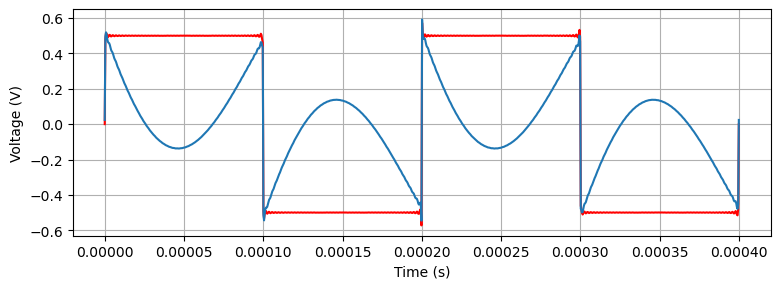

In [18]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import pandas as pd

R = 5000
C = 20 * 10**(-9)
L = 50 * 10**(-3)
T0 = 2 * 10**(-4)

numerator = [C*L*R, 0, R]
denominator = [C*L*R, L, R]

# Square wave fourier terms
SwaveFrq = lambda n : (2*n-1)*2*np.pi/T0
SwaveAmp = lambda n : 2/(np.pi * (2*n-1))
Swaveterm = lambda n,t : SwaveAmp(n) * np.sin(SwaveFrq(n)*t)

# Evaluate transfer function
transferF = lambda s: np.polyval(numerator, s) / np.polyval(denominator, s)

Ao, Bo = list(), list()

for i in range(1,9 + 1):
    Ao.append(SwaveAmp(i)*np.absolute(transferF(1j*SwaveFrq(i))))
    Bo.append(np.angle(transferF(1j*SwaveFrq(i)), deg=True))


df = pd.DataFrame({'f_i' : (SwaveFrq(i)/(2*np.pi) for i in range(1,9+1)),
                   'A_i' : (SwaveAmp(i) for i in range(1,9+1)),
                  'A_oi': (SwaveAmp(i)*np.absolute(transferF(1j*SwaveFrq(i))) for i in range(1,9+1)),
                   'B_oi' : (np.angle(transferF(1j*SwaveFrq(i)), deg=True) for i in range(1,9+1))},
                  index=[i for i in range(1, 9 + 1)])
print(df)

nTerms = 300
maxTime = 0.0004

tInput = np.linspace(0,maxTime,1000)
InSine = lambda n, t : SwaveAmp(n) * np.sin(SwaveFrq(n) * t)
OutSine = lambda n, t : SwaveAmp(n) * np.absolute(transferF(1j*SwaveFrq(n))) * np.sin(SwaveFrq(n) * t + np.angle(transferF(1j*SwaveFrq(n)), deg=False))

plt.figure(figsize=(9, 3), dpi=100)
#plt.plot(tInput, 0.5 + OutSine(1,tInput,np.absolute(transferF(1j*SwaveFrq(1))),Bo[1]) + OutSine(2,tInput,np.absolute(transferF(1j*SwaveFrq(2))),Bo[2]) + OutSine(3,tInput,np.absolute(transferF(1j*SwaveFrq(3))),Bo[3]), color='r')
plt.plot(tInput, sum((InSine(k,tInput) for k in range(1,nTerms))), 'r')
plt.plot(tInput, sum((OutSine(k,tInput) for k in range(1,nTerms))))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid()

In [15]:
%%latex
\begin{table}[]
\centering
\begin{tabular}{llll}
\multicolumn{1}{l|}{$n$} & \multicolumn{1}{l|}{$A_{in}$} & \multicolumn{1}{l|}{$A_{out}$} & $B_{out}$  \\ \hline
1                        & 1.273240                      & 0.052802                       & -87.623234 \\
2                        & 0.424413                      & 0.421508                       & -6.708195  \\
3                        & 0.254648                      & 0.254105                       & -3.742631  \\
4                        & 0.181891                      & 0.181701                       & -2.622454  \\
5                        & 0.141471                      & 0.141383                       & -2.023828  \\
6                        & 0.115749                      & 0.115701                       & -1.649365  \\
7                        & 0.097942                      & 0.097913                       & -1.392475  \\
8                        & 0.084883                      & 0.084864                       & -1.205109  \\
9                        & 0.074896                      & 0.074884                       & -1.062330
\end{tabular}
\end{table}

<IPython.core.display.Latex object>